<large>
<b>Purpose & Pipeline</b>

This notebook evaluates machine-learning models to forecast <b>quarterly dwelling starts</b> per province using the prepared dataset <code>data/housing_adequacy_dataset.csv</code>. The target is <code>dwelling_starts</code>; features are selected based on the chosen prediction horizon:

• <b>next_quarter</b> → H=1 (t+1)  
• <b>same_quarter_next_year</b> → H=4 (t+4, same quarter next year)

<b>End-to-end flow:</b>
1. <i>Configuration</i>: Reproducibility, plotting, and library imports.
2. <i>Utilities</i>: Load helper functions from <code>utilities/01_func_dwelling.py</code>.
3. <i>Load & Frame</i>: Read the dataset, build a modeling frame with lags/exogenous drivers.
4. <i>Feature Choice</i>: Select features consistent with the horizon (H).
5. <i>Split</i>: Chronological train/test based on <code>CUTOFF_DATE</code> (train ≤ cutoff, test > cutoff).
6. <i>Tuning</i>: For each model, random/heuristic hyperparameter search (or load cache).
7. <i>Holdout Fit/Pred</i>: Train per-province, predict on test, and compute metrics.
8. <i>Baselines</i>: Add seasonal-naïve baseline for fair MASE comparison.
9. <i>Visualization</i>: Overlays of predictions vs truth; rolling evaluation (evolving cutoff).
10. <i>Diagnostics</i>: Heatmaps of error metrics; province-level leaderboard and ranks.

<b>Key metric:</b> <code>MASE</code> compares a model's forecast errors against the seasonal-naïve baseline (values &lt; 1 mean beating the baseline). We also report MAE, RMSE, and sMAPE.

<b>Notes:</b>
• Housing starts in the CSV were converted from SAAR to quarterly units during preprocessing.  
• Province-level models are trained independently; national aggregation is evaluated from provincial results when needed.  
• Tuning is limited (<code>n_iter</code>) for speed; increase it for deeper searches.
</large>


## Here we use H=1

In [1]:
# ===============================
# Imports & Global Config
# ===============================
import os, json, math, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140
sns.set_context("notebook")


<large>
<b>Utility Functions</b>

Load all helper utilities (feature construction, tuning, splits, plotting).  
This notebook assumes <code>01_func_dwelling.py</code> provides:
• <code>build_model_frame</code> – assemble features/target  
• <code>features_for_choice</code> – pick feature set + horizon H per choice  
• <code>chrono_split</code> – chronological train/test split  
• <code>load_or_tune_best_params</code> – cache-aware hyperparameter tuning  
• <code>fit_predict_holdout_per_province</code> – per-province fit/predict  
• <code>add_naive_to_holdout</code> – add seasonal naïve baseline  
• <code>plot_holdout_overlay</code>, <code>rolling_evolution_overlay</code>, <code>latest_per_quarter</code>, <code>rolling_overlay_lines</code> – visual diagnostics  
• <code>summarize_metrics_table</code>, <code>plot_perf_heatmaps_from_preds</code>, <code>rank_models_across_provinces</code>, <code>add_row_metrics_for_rolling</code> – scoring & ranking
</large>


In [2]:
%run utilities/01_func_dwelling.py

<large>
<b>Data & Split Configuration</b>

• <code>DATA_PATH</code> points to the prebuilt quarterly dataset with features.  
• <code>CUTOFF_DATE</code> defines the time-based split: train ≤ cutoff, test > cutoff.  
• <code>ALL_MODELS</code> selects which models to train (trim as needed for speed).
</large>

In [3]:

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
DATA_PATH  = "data/housing_adequacy_dataset.csv"

# Split
CUTOFF_DATE = "2018-12-31"  # train ≤ cutoff, test > cutoff

# Available models
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]  # trim as needed

# ===============================
# Choose prediction target here:
# "next_quarter"            -> H=1
# "same_quarter_next_year"  -> H=4
# ===============================

<large>
<b>Horizon Selection</b>

Choose the forecasting horizon:
• <b>next_quarter</b> → H=1 (predict t+1)  
• <b>same_quarter_next_year</b> → H=4 (predict t+4, same quarter next year)

This choice determines the feature set (lags/exogenous) returned by <code>features_for_choice</code> and the forecasting horizon used throughout.
</large>


In [4]:

# ===============================
# Run: load, prep, select features by choice, tune/load cache, evaluate, visualize
# ===============================

PREDICTION_CHOICE = "next_quarter"  # or "next_quarter"


<large>
<b>Load & Build Modeling Frame</b>

Read the prepared dataset and construct the modeling frame (features + target <code>y</code>).  
The builder handles lag features and required transformations consistently with prior preprocessing.
</large>

In [5]:

# Load + frame
raw = pd.read_csv(DATA_PATH)
model_df = build_model_frame(raw)


<large>
<b>Time Index Normalization</b>

Ensure the <code>quarter</code> column has a proper datetime dtype to support chronological splits and plotting.  
Any parsing failures become NaT (coerced).
</large>


In [6]:

# Ensure datetime dtype
model_df["quarter"] = pd.to_datetime(model_df["quarter"], errors="coerce")


<large>
<b>Feature Set for the Chosen Horizon</b>

Select the horizon (<code>H</code>) and the corresponding feature list (<code>feat_cols</code>) using <code>features_for_choice</code>.  
This keeps experiments comparable across different horizons with consistent inputs.
</large>

In [7]:

# Choose features by prediction choice
H, feat_cols = features_for_choice(PREDICTION_CHOICE)
print(f"Mode: {PREDICTION_CHOICE} | Horizon H={H}")
print("Features:", feat_cols)


Mode: next_quarter | Horizon H=1
Features: ['dwelling_starts_lag1', 'dwelling_starts_lag4', 'pop_change_q_lag1', 'needed_units_q_lag1']


<large>
<b>Row Filtering</b>

Drop rows with missing values in the chosen <code>feat_cols</code> or target <code>y</code>.  
This ensures each model sees the same clean sample for fair evaluation.
</large>

In [8]:

# Remove rows with NaNs in chosen features/target
safe_df = model_df.dropna(subset=feat_cols + ["y"]).copy()


<large>
<b>Chronological Holdout Split</b>

Split into train/test using <code>CUTOFF_DATE</code> (train ≤ cutoff, test > cutoff).  
This mimics real forecasting, preventing look-ahead leakage.
</large>


In [9]:

# Holdout split
train, test = chrono_split(safe_df, cutoff=CUTOFF_DATE)
print(f"Train: {train['quarter'].min().date()} → {train['quarter'].max().date()} | "
      f"Test: {test['quarter'].min().date()} → {test['quarter'].max().date()}")


Train: 1991-01-01 → 2018-10-01 | Test: 2019-01-01 → 2025-07-01


<large>
<b>Hyperparameter Tuning (Cache-Aware)</b>

Tune model hyperparameters on the training period (per model) or load cached best params.  
Set <code>n_iter</code> higher for deeper searches; current value balances speed and performance.  
The cache key includes the prediction choice to keep H=1 vs H=4 runs separate.
</large>


In [10]:

# Tune or load cached best params (cache key depends on choice)
best_params = load_or_tune_best_params(
    train_df=train,
    features=feat_cols,
    models_to_run=ALL_MODELS,
    prediction_choice=PREDICTION_CHOICE,
    n_iter=8,     # increase if you want more thorough tuning
    fh=H,
    initial=None,
)


🔁 Loading cached best parameters from best_params_cache_h1.json


<large>
<b>Fit on Train, Predict on Test (Per Province)</b>

Train each selected model by province on the train set and generate predictions on the test set.  
Outputs include per-quarter forecasts and evaluation metrics against ground truth.
</large>


In [11]:

# Final fit on TRAIN + predict on TEST
preds_holdout = fit_predict_holdout_per_province(
    train_df=train, test_df=test, features=feat_cols,
    models_to_run=ALL_MODELS, best_params=best_params,
    prediction_choice=PREDICTION_CHOICE, target="dwelling_starts"
)


<large>
<b>Summaries & Seasonal-Naïve Baseline</b>

Summarize performance across provinces.  
Add a <b>seasonal-naïve</b> baseline (e.g., last year’s same-quarter) so <code>MASE</code> is interpretable (values &lt; 1 beat the baseline).
</large>


In [12]:

# Summary tables
print("\n=== Holdout averages across provinces (tuned) ===")
g_model, g_pm = summarize_metrics_table(preds_holdout)

naive_holdout = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_holdout_with_naive = pd.concat([preds_holdout, naive_holdout], ignore_index=True)




=== Holdout averages across provinces (tuned) ===


,MAE,RMSE,sMAPE,MASE
model,,,,
ridge,1262.46,1624.43,22.60,1.69
lr,1269.97,1618.60,22.32,1.68
etr,1727.98,2078.84,26.71,2.06
rf,1743.90,2101.72,26.68,2.05
xgb,1777.31,2152.05,28.84,2.16


<large>
<b>Holdout Overlays</b>

Visual comparison of predictions vs truth on the test period by province.  
Use the multi-model overlay for a broad view, and a focused overlay (e.g., <code>lr</code> vs <code>naive</code>) for clarity.
</large>


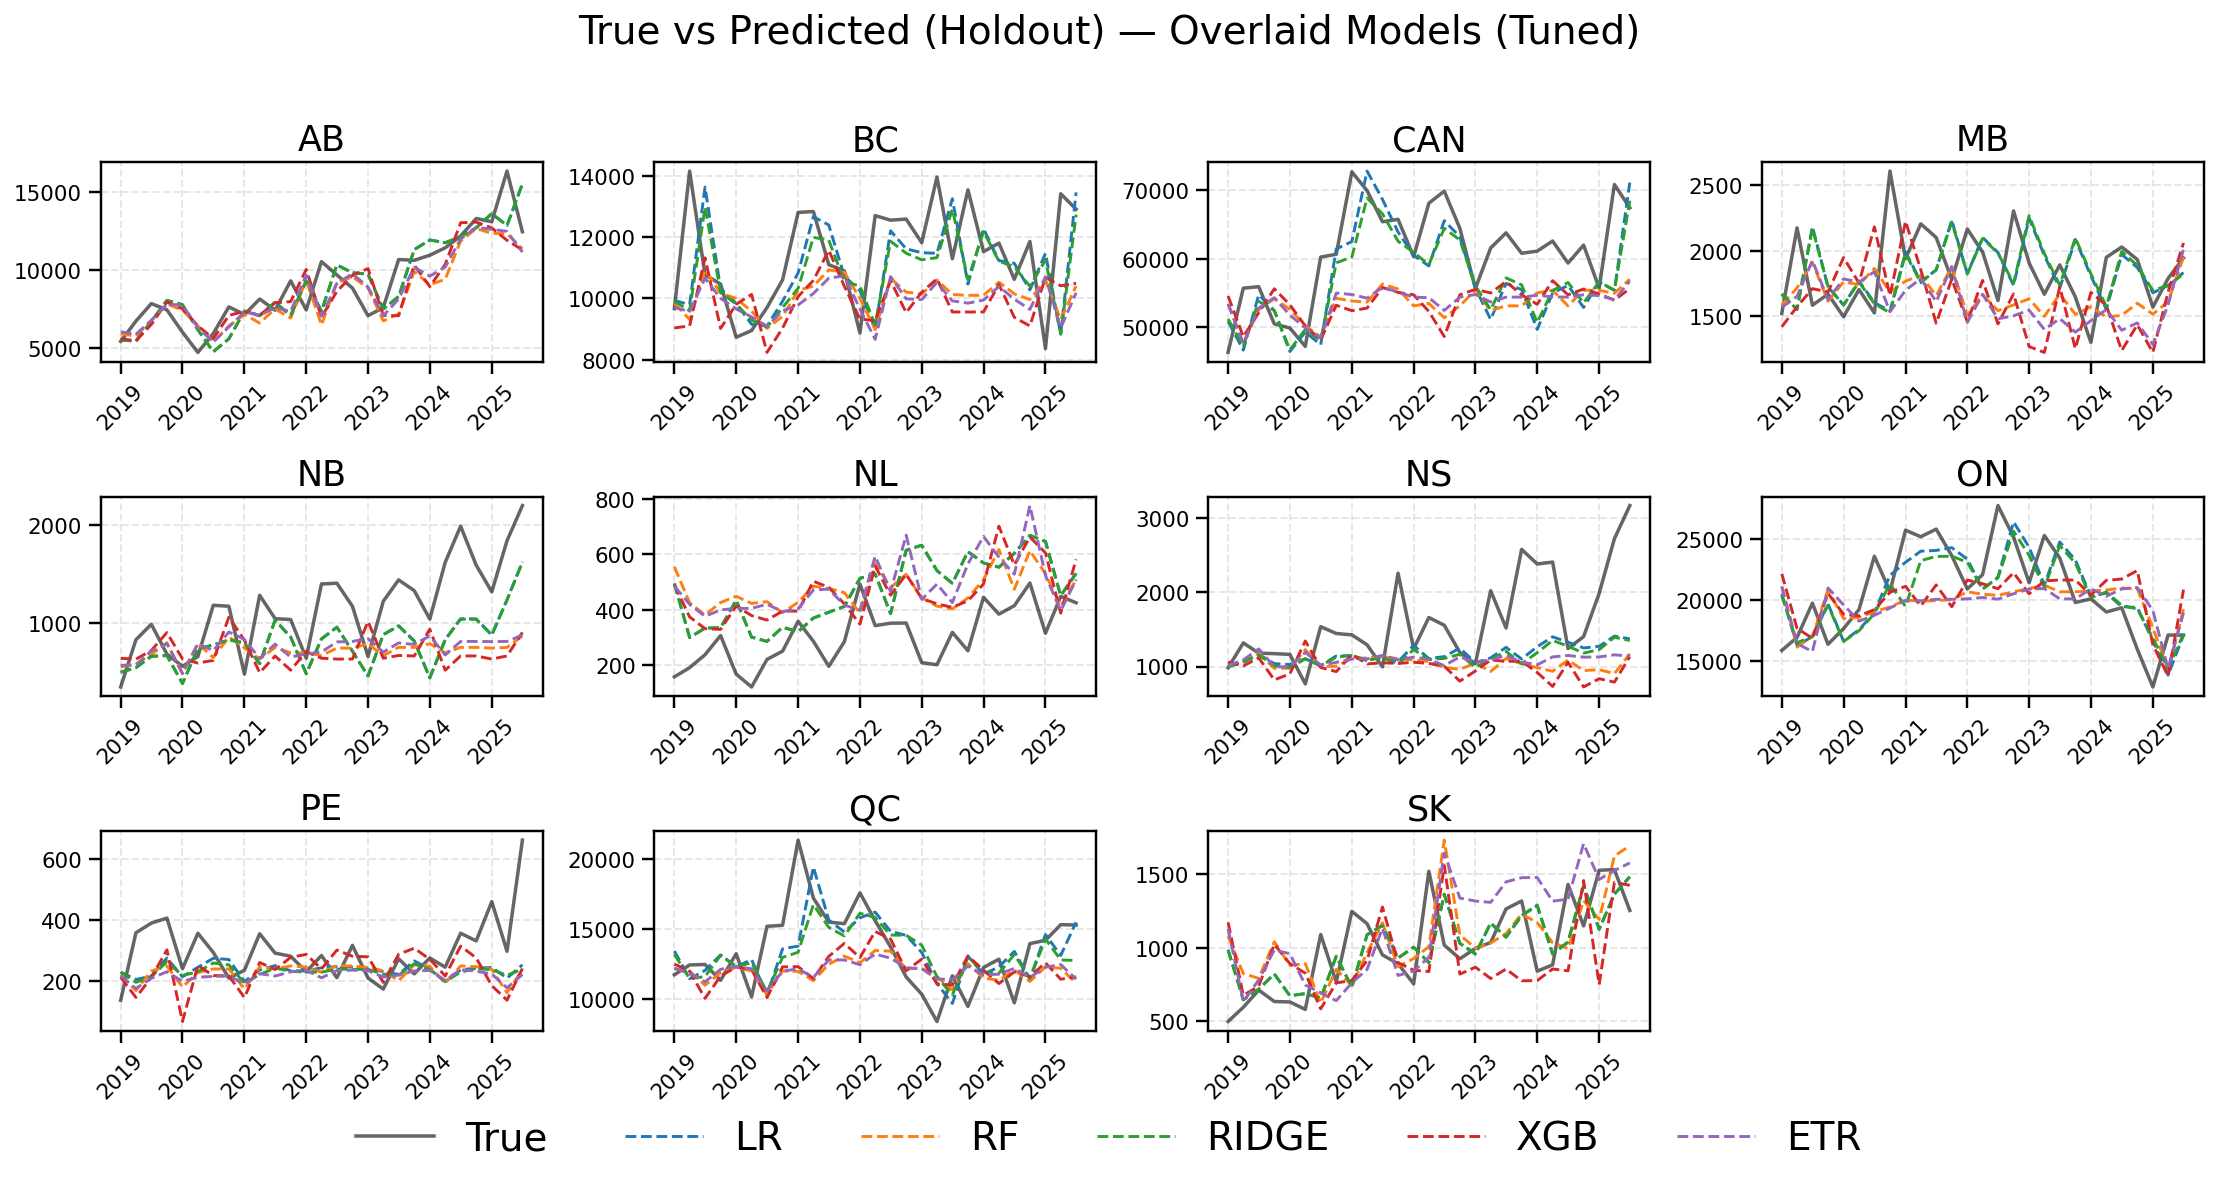

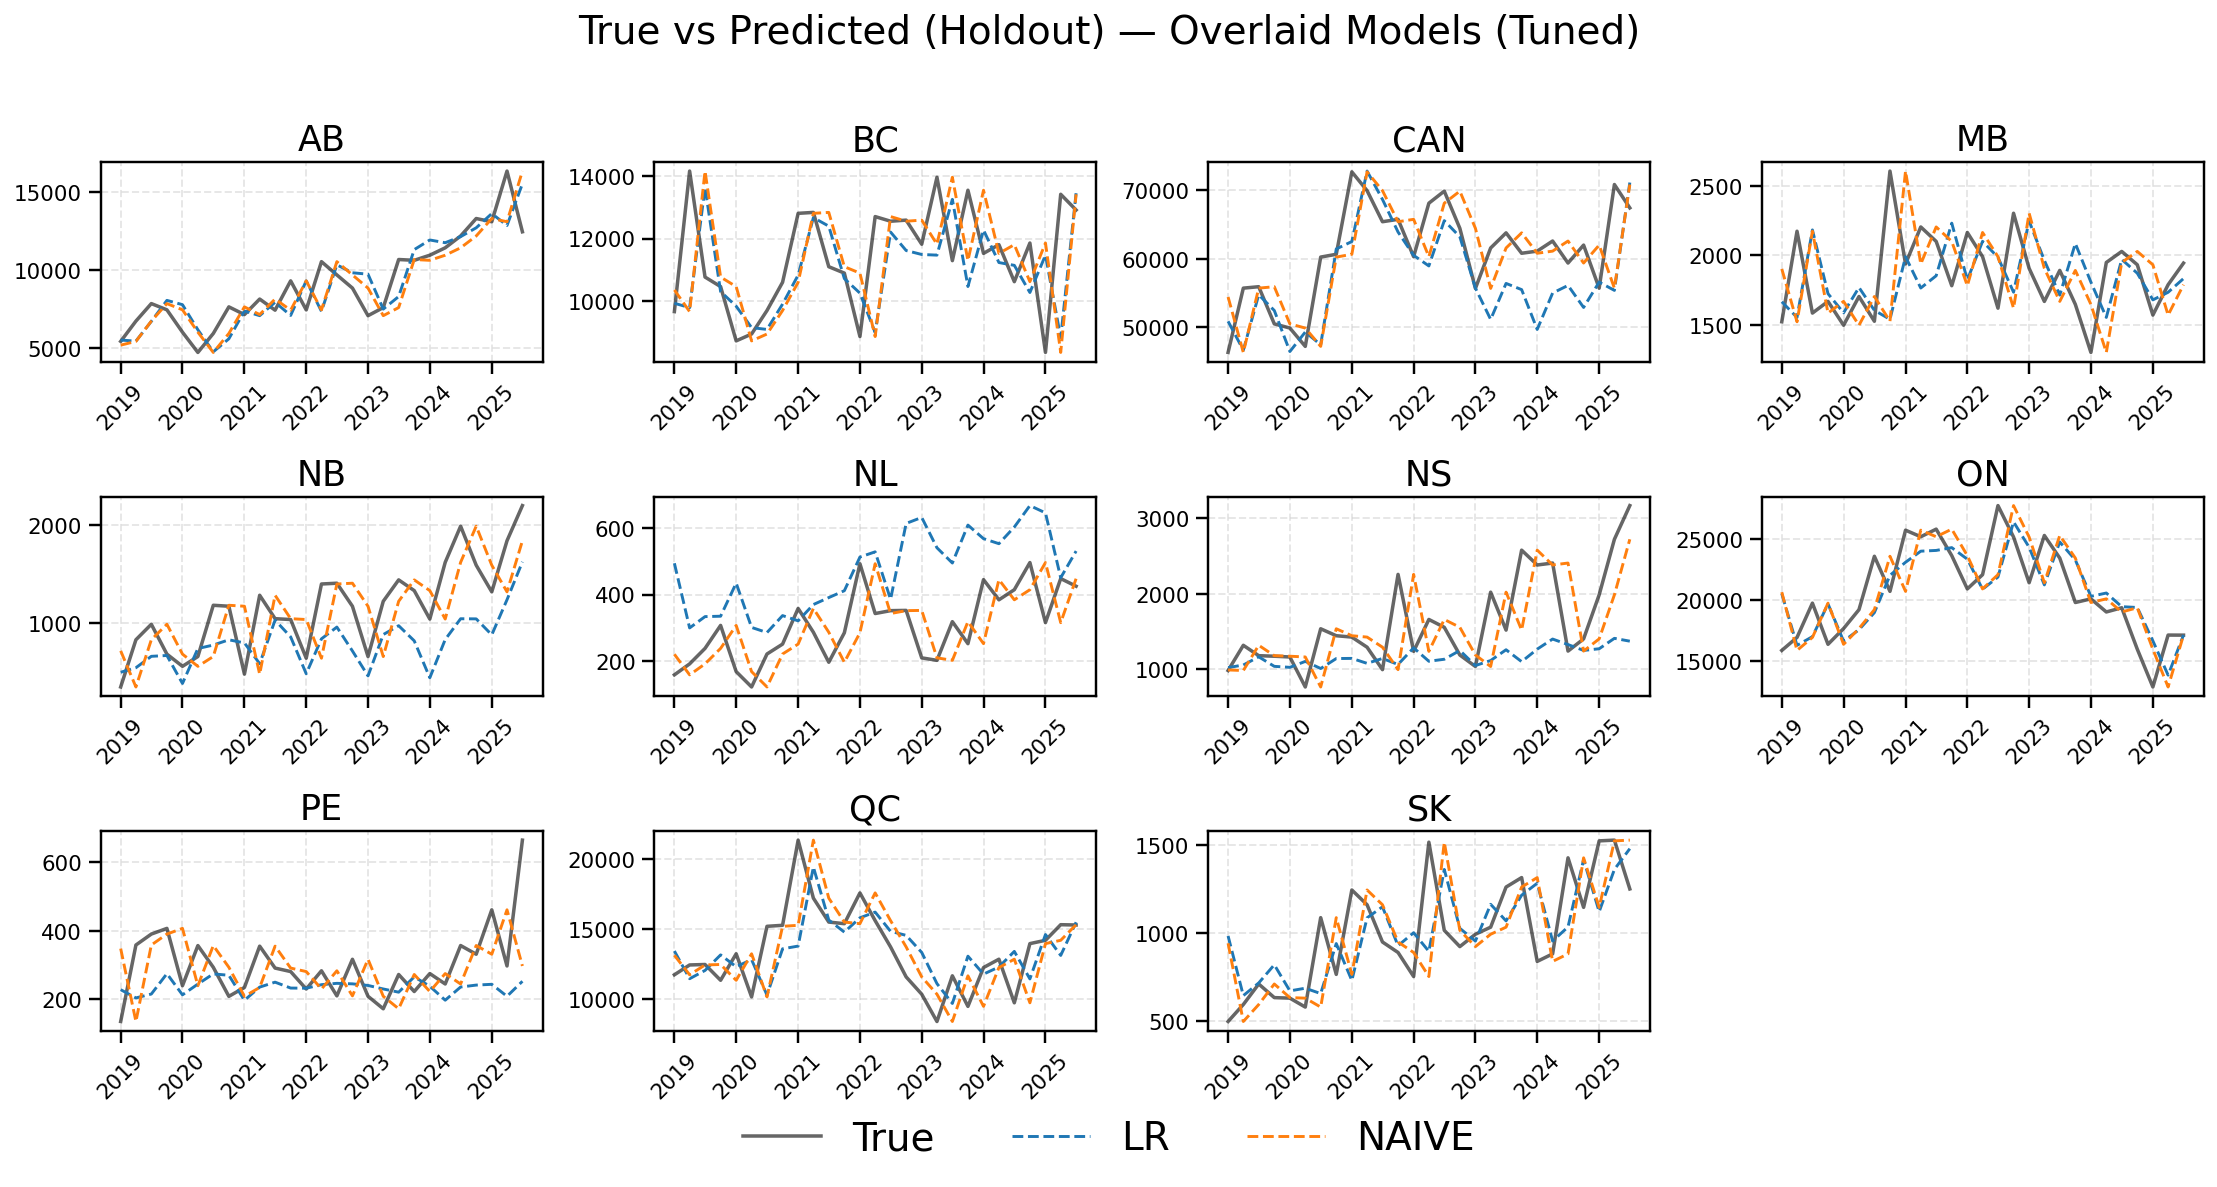

In [13]:

# Train–Test overlay (multiple models per province)
plot_holdout_overlay(preds_holdout_with_naive, ALL_MODELS)

plot_holdout_overlay(preds_holdout_with_naive, ['lr', 'naive'])


<large>
<b>Rolling Evaluation (Evolving Cutoff)</b>

Assess temporal stability by refitting models over multiple rolling cutoffs.  
This shows how model performance evolves as new data arrive and whether wins vs baseline persist.  
Parameters: <code>initial</code> starting cutoff, <code>step</code> cadence, <code>last_k_cutoffs</code> number of latest folds to visualize.
</large>


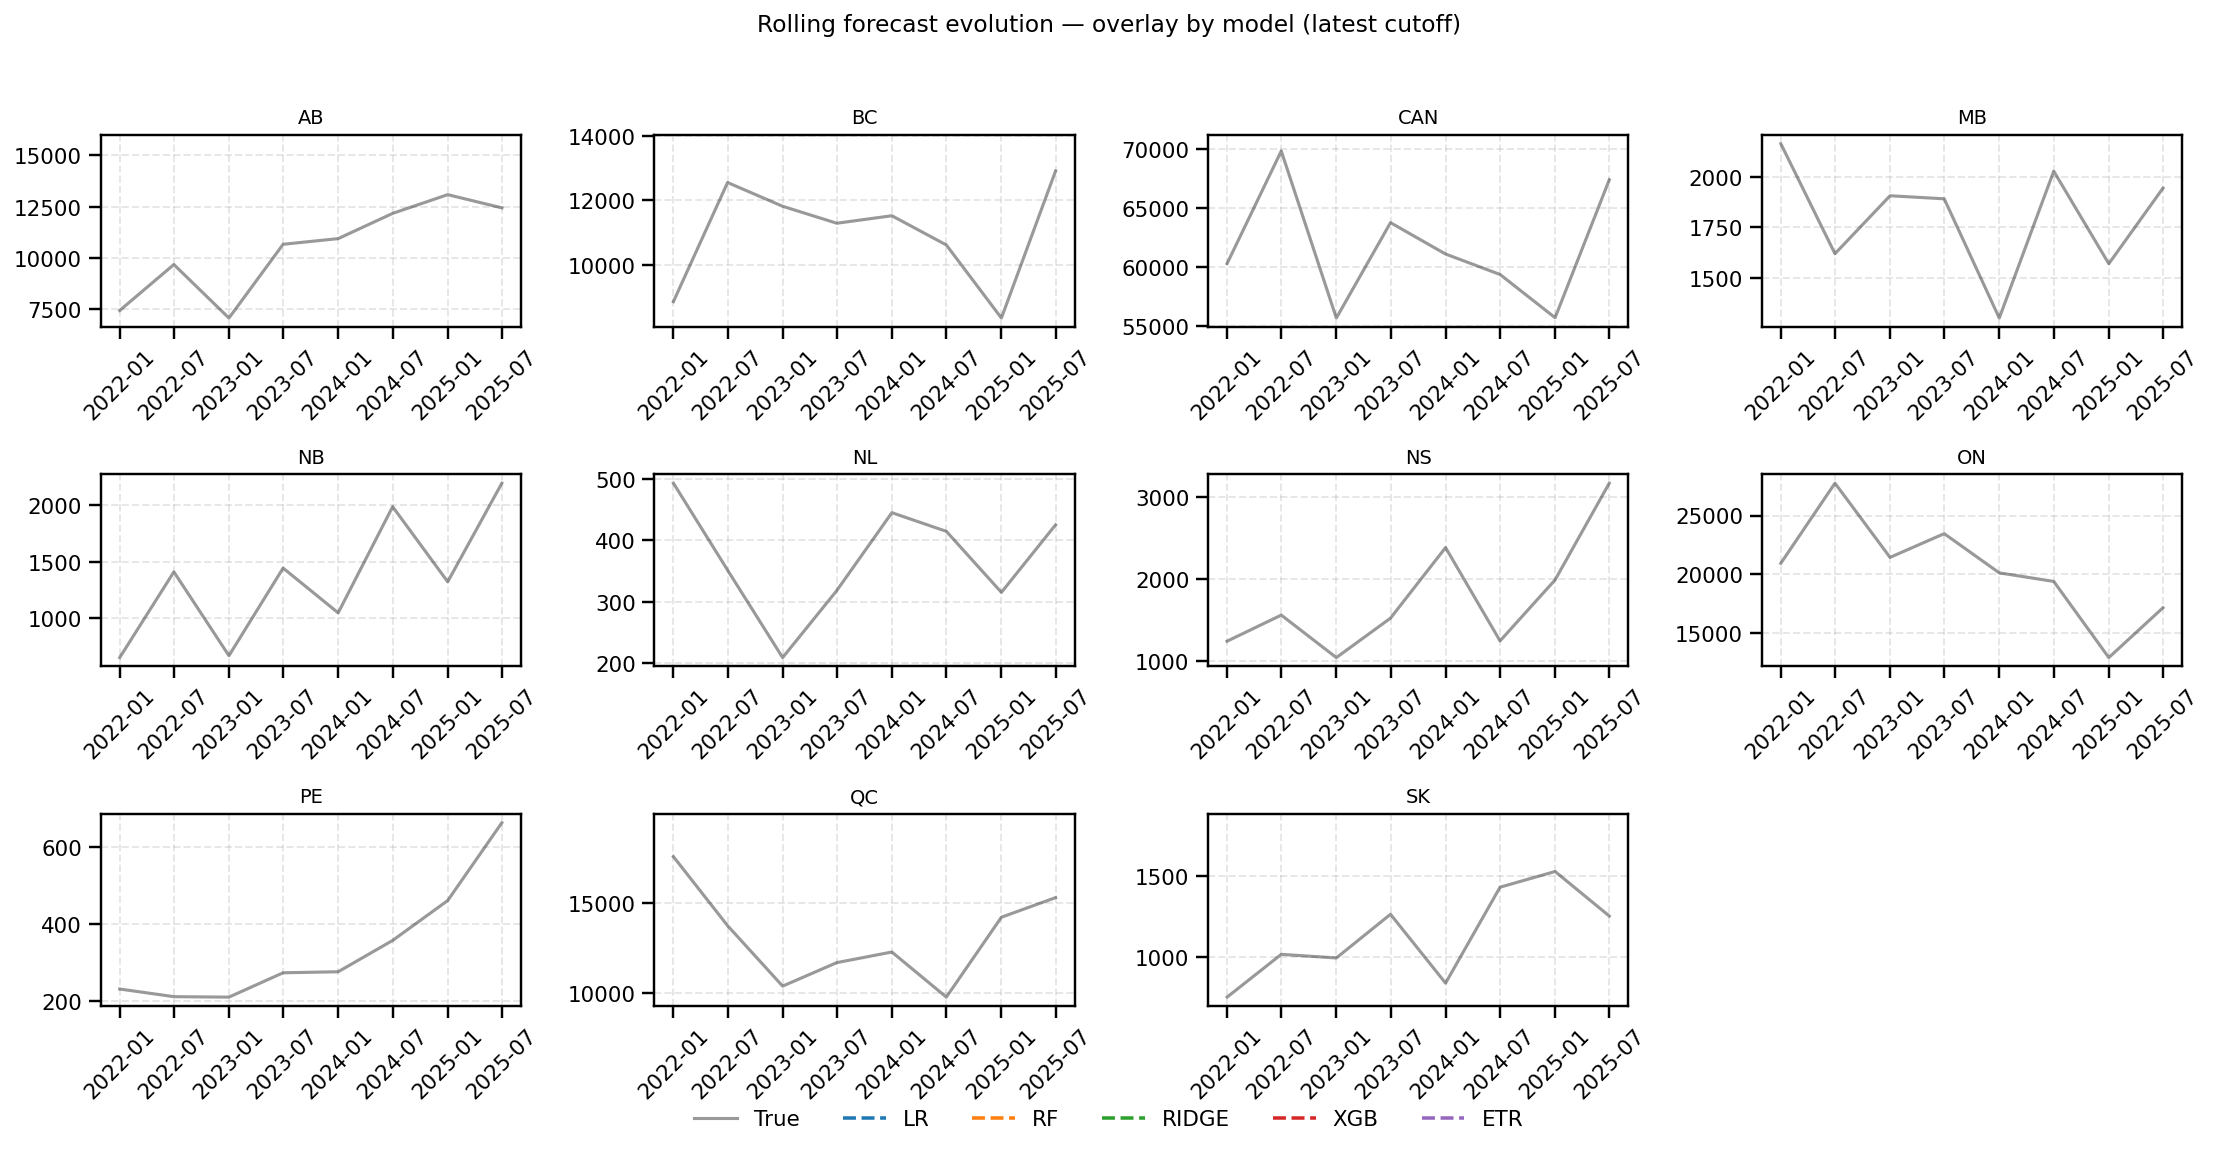

In [14]:

# Rolling evolution — latest cutoff overlay
preds_roll = rolling_evolution_overlay(
    df_all=safe_df,
    features=feat_cols,
    best_params=best_params,
    models_to_plot=ALL_MODELS,
    fh=H,
    initial="2012-12-31",
    step=2,                  # speed/coverage trade-off
    last_k_cutoffs=8,
    show_history=False,
    return_df=True,
)

naive_roll = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_roll_with_naive = pd.concat([preds_roll, naive_roll], ignore_index=True)



<large>
<b>Rolling Stitched Lines</b>

For each quarter, keep the latest available forecast across folds to build a single stitched time series per model.  
This approximates “what would we have forecast at each quarter using only past data.”
</large>


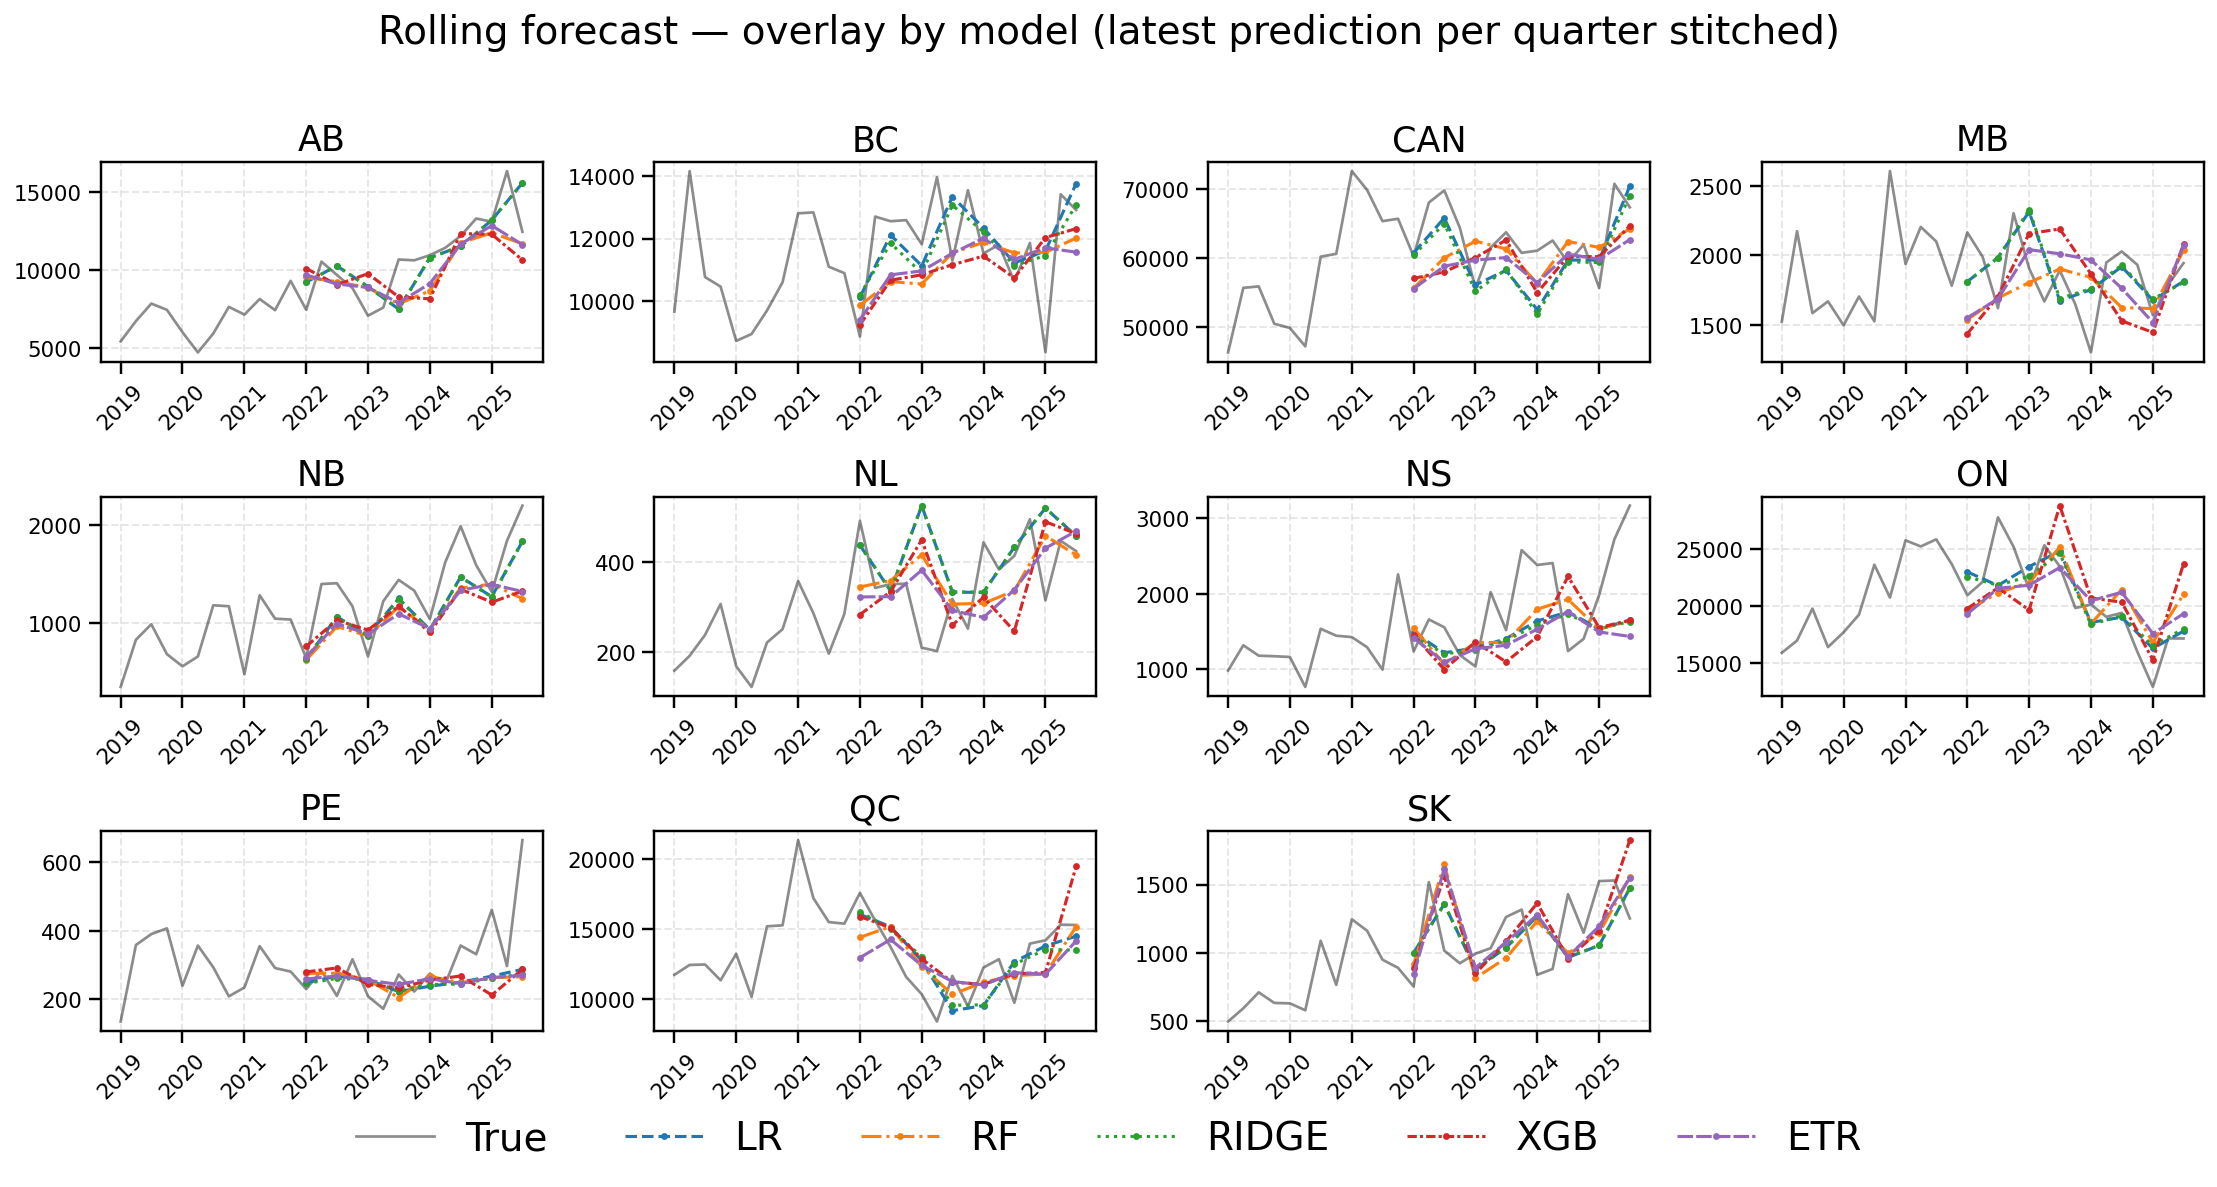

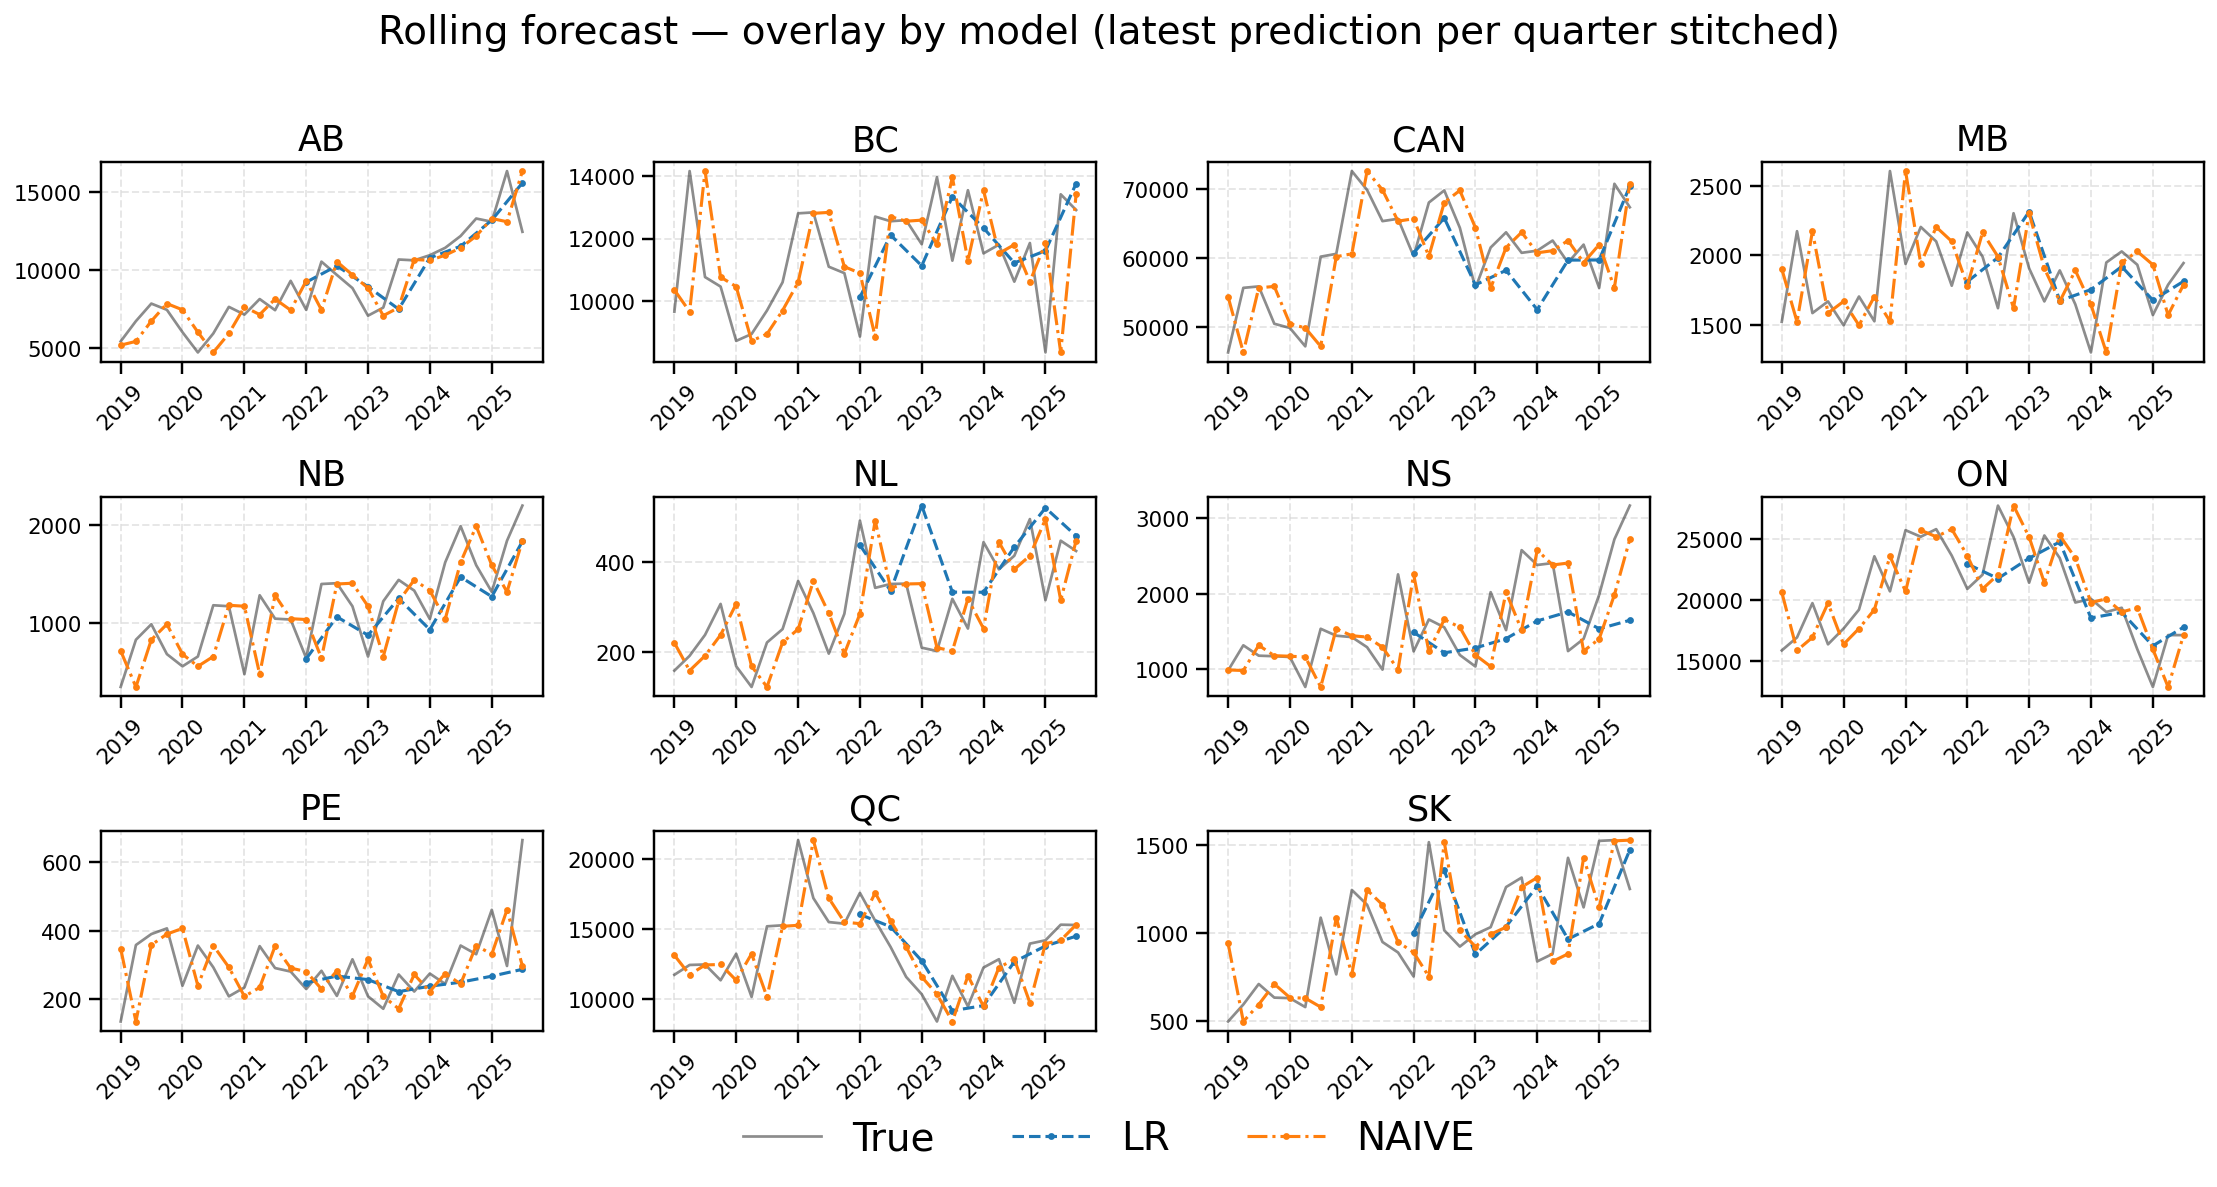

,cutoff,province,model,quarter,y_true,y_pred,MASE_denom,cut_rank
4,2021-10-01,ab,etr,2022-01-01,7420.750000,9661.334375,801.173442,0
59,2022-04-01,ab,etr,2022-07-01,9667.833333,9089.288333,828.096667,1
114,2022-10-01,ab,etr,2023-01-01,7050.416667,8862.312500,828.433727,2
169,2023-04-01,ab,etr,2023-07-01,10658.250000,7875.479375,833.354005,3
224,2023-10-01,ab,etr,2024-01-01,10934.833333,9110.309167,844.601145,4
279,2024-04-01,ab,etr,2024-07-01,12168.916667,11650.572708,837.944236,5
334,2024-10-01,ab,etr,2025-01-01,13085.666667,12836.341458,839.462963,6
389,2025-04-01,ab,etr,2025-07-01,12439.125000,11614.136667,852.466545,7
0,2021-10-01,ab,lr,2022-01-01,7420.750000,9201.846400,801.173442,0
55,2022-04-01,ab,lr,2022-07-01,9667.833333,10252.059538,828.096667,1


In [15]:

# Rolling stitched lines (latest per quarter across folds)
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ALL_MODELS)
    
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ['lr', 'naive'])

# Peek
preds_roll.head(10) if preds_roll is not None else None


<large>
<b>Performance Heatmaps (Holdout)</b>

Heatmaps of <code>MASE</code>, <code>MAE</code>, <code>RMSE</code>, and <code>sMAPE</code> across provinces and models.  
Centering MASE at 1 highlights improvements vs the seasonal-naïve baseline.
</large>


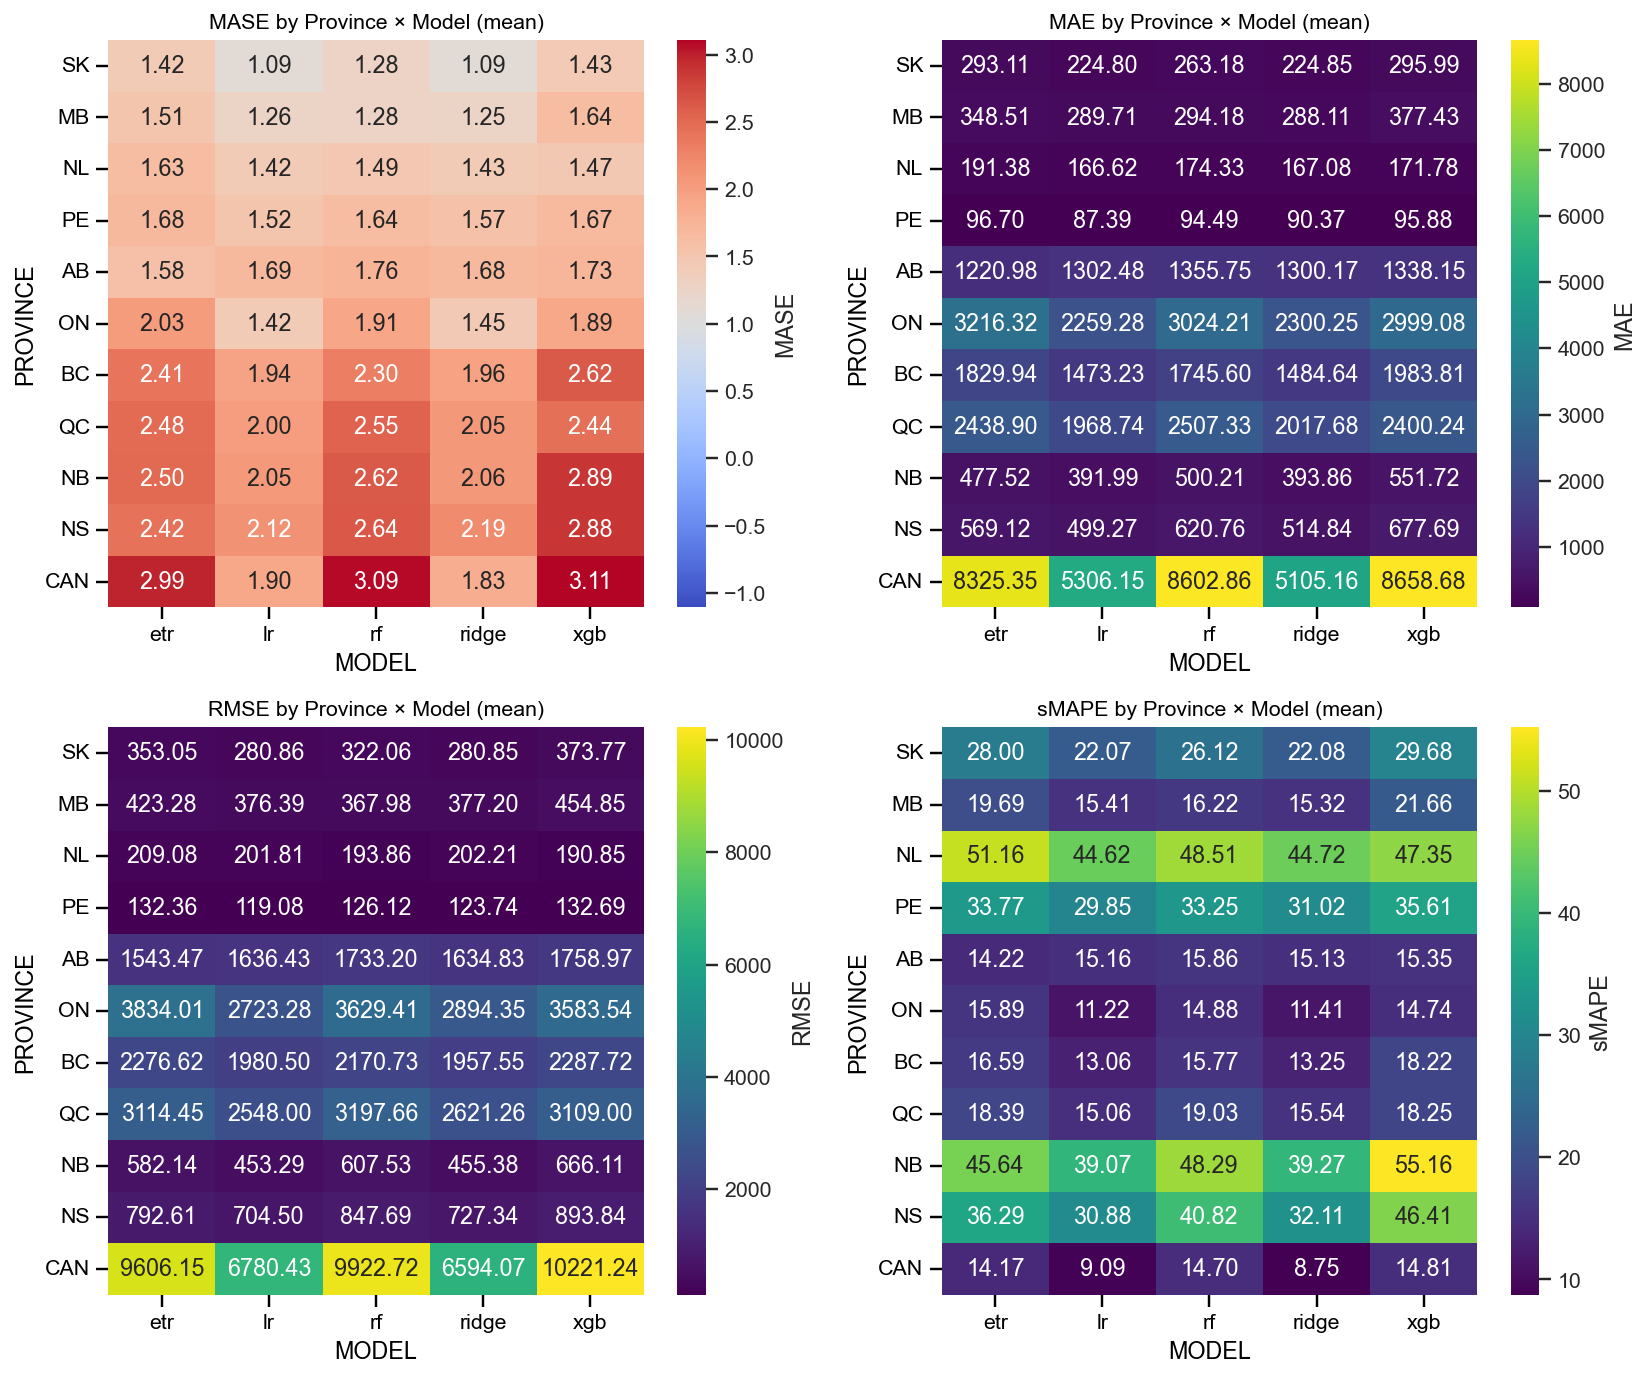

In [16]:
no_naive = preds_holdout_with_naive[preds_holdout_with_naive["model"].str.lower() != "naive"]
plot_perf_heatmaps_from_preds(
    preds_df=no_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_fallback_to_existing_col=True
)


<large>
<b>Model Ranking (Holdout)</b>

Aggregate metrics by province and model; rank models (e.g., by mean MASE).  
Inspect the overall leaderboard and the best model per province to see consistent winners and regional differences.
</large>


In [17]:

per_prov_rank, leaderboard, best_by_prov = rank_models_across_provinces(
    preds_df=no_naive,
    metric="MASE",        # choose "MASE", "MAE", "RMSE", or "sMAPE"
    agg="mean",           # average across quarters per (province, model)
    rank_method="dense"
)

print("=== Overall leaderboard (by MASE) ===")
display(leaderboard)

print("=== Best model per province (by MASE) ===")
display(best_by_prov)

print("=== Full province–model ranking table ===")
display(per_prov_rank)

sameQ_hold_df = preds_holdout_with_naive.copy()

=== Overall leaderboard (by MASE) ===


,model,wins,avg_rank,med_rank,mean_metric,n_provinces
0,LR,8,1.363636,1.0,1.675430,11
1,RIDGE,2,1.818182,2.0,1.688227,11
2,ETR,1,3.727273,4.0,2.060503,11
3,RF,0,3.818182,4.0,2.050044,11
4,XGB,0,4.272727,5.0,2.161114,11


=== Best model per province (by MASE) ===


,province,model,metric_agg,n,rank
0,SK,lr,1.089814,27,1.0
1,MB,ridge,1.251635,27,1.0
2,NL,lr,1.421276,27,1.0
3,ON,lr,1.424725,27,1.0
4,PE,lr,1.518646,27,1.0
5,AB,etr,1.581092,27,1.0
6,CAN,ridge,1.832231,27,1.0
7,BC,lr,1.943931,27,1.0
8,QC,lr,2.004769,27,1.0
9,NB,lr,2.053531,27,1.0


=== Full province–model ranking table ===


,province,model,metric_agg,n,rank
0,AB,etr,1.581092,27,1.0
1,AB,ridge,1.683643,27,2.0
2,AB,lr,1.686631,27,3.0
3,AB,xgb,1.732824,27,4.0
4,AB,rf,1.755605,27,5.0
5,BC,lr,1.943931,27,1.0
6,BC,ridge,1.958988,27,2.0
7,BC,rf,2.303335,27,3.0
8,BC,etr,2.414622,27,4.0
9,BC,xgb,2.617649,27,5.0


<large>
<b>Rolling Metrics & Ranking</b>

Compute per-row metrics for rolling forecasts, drop the naïve rows, and generate heatmaps again.  
Rank models on rolling performance (e.g., by mean MASE) to confirm holdout conclusions are stable over time.
</large>


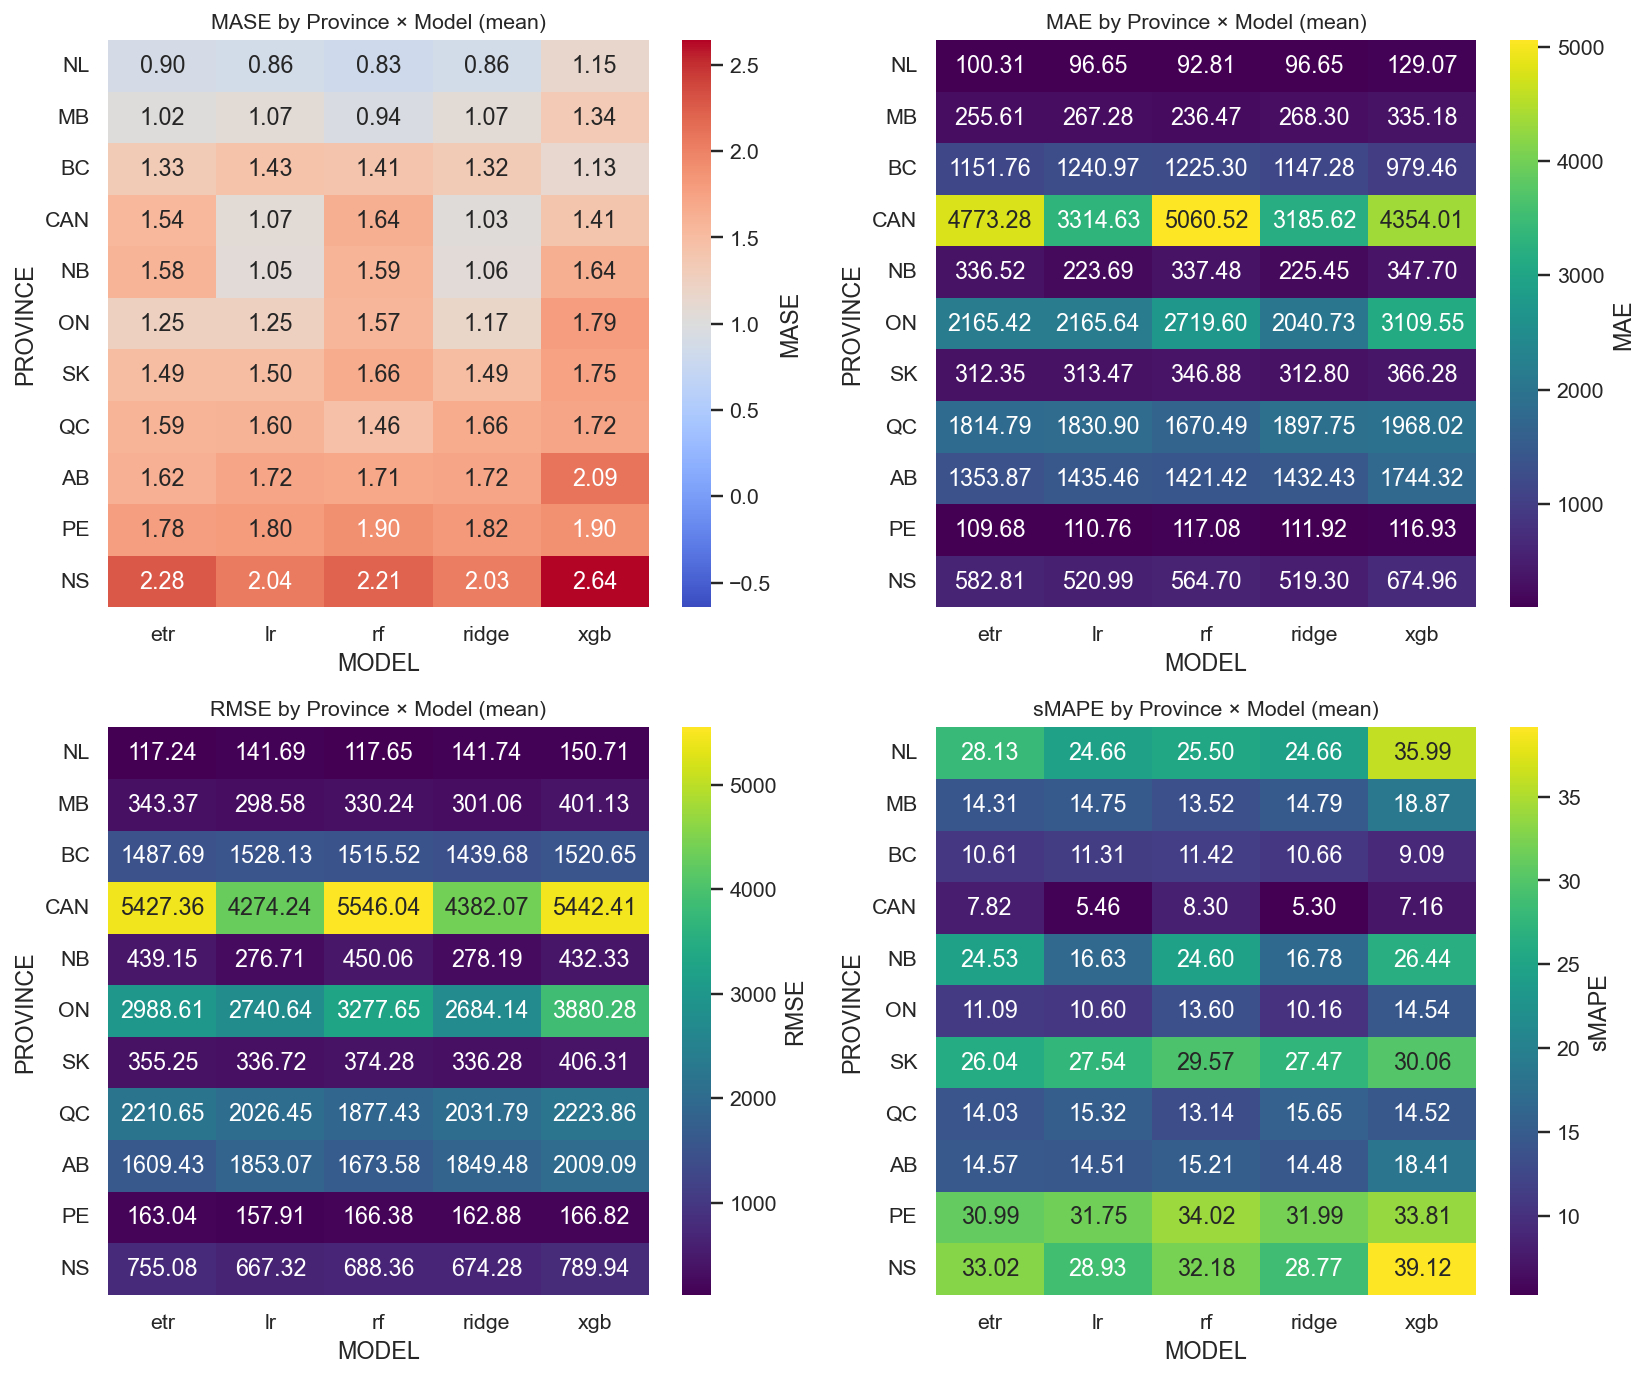

=== Overall leaderboard (by MASE) ===


,model,wins,avg_rank,med_rank,mean_metric,n_provinces
0,ETR,3,2.363636,2.0,1.483823,11
1,RIDGE,3,2.454545,3.0,1.382189,11
2,RF,3,3.090909,4.0,1.533625,11
3,LR,1,2.727273,3.0,1.395549,11
4,XGB,1,4.363636,5.0,1.680120,11


=== Best model per province (by MASE) ===


,province,model,metric_agg,n,rank
0,NL,rf,0.829135,8,1.0
1,MB,rf,0.944921,8,1.0
2,CAN,ridge,1.024844,8,1.0
3,NB,lr,1.046505,8,1.0
4,BC,xgb,1.125365,8,1.0
5,ON,ridge,1.186078,8,1.0
6,QC,rf,1.471798,8,1.0
7,SK,etr,1.490143,8,1.0
8,AB,etr,1.633154,8,1.0
9,PE,etr,1.766940,8,1.0


=== Full province–model ranking table ===


,province,model,metric_agg,n,rank
0,AB,etr,1.633154,8,1.0
1,AB,rf,1.711911,8,2.0
2,AB,ridge,1.720274,8,3.0
3,AB,lr,1.723902,8,4.0
4,AB,xgb,2.099443,8,5.0
5,BC,xgb,1.125365,8,1.0
6,BC,etr,1.316281,8,2.0
7,BC,ridge,1.332946,8,3.0
8,BC,rf,1.412180,8,4.0
9,BC,lr,1.431759,8,5.0


In [18]:
no_naive = preds_roll_with_naive[preds_roll_with_naive["model"].str.lower() != "naive"]

plot_perf_heatmaps_from_preds(
    preds_df=no_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_denom_col="MASE_denom"
)

roll_scored = add_row_metrics_for_rolling(preds_roll_with_naive)
roll_scored = roll_scored[roll_scored["model"].str.lower() != "naive"]

per_prov_rank, leaderboard, best_by_prov = rank_models_across_provinces(
    preds_df=roll_scored,
    metric="MASE",        # choose "MASE", "MAE", "RMSE", or "sMAPE"
    agg="mean",           # average across quarters per (province, model)
    rank_method="dense"
)

print("=== Overall leaderboard (by MASE) ===")
display(leaderboard)

print("=== Best model per province (by MASE) ===")
display(best_by_prov)

print("=== Full province–model ranking table ===")
display(per_prov_rank)

sameQ_roll_df = roll_scored.copy()